# Лабораторная работа 2: Классификация с использованием ансамблевых методов

## Описание
В данной работе реализуются алгоритмы бэггинга и градиентного бустинга, различные метрики классификации,
и проводится сравнение различных моделей для задачи бинарной классификации.

**Цель:** Предсказать LoanApproved (одобрение кредита) на основе признаков из датасета

**Метрика:** ROC-AUC (минимальный порог: 0.75)

## 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 2. Загрузка данных

In [2]:
# Загрузка обучающих данных (с целевой переменной LoanApproved)
train = pd.read_csv('train_c.csv')

# Загрузка тестовых данных (БЕЗ целевой переменной, только для submission)
test = pd.read_csv('test_c.csv')

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки (для Kaggle): {test.shape}")
print(f"\nКолонки в train: {train.columns.tolist()[:10]}...")
print(f"\nКолонки в test: {test.columns.tolist()[:10]}...")
print(f"\nПервые строки обучающей выборки:")
train.head()

Размер обучающей выборки: (11017, 35)
Размер тестовой выборки (для Kaggle): (5000, 35)

Колонки в train: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments']...

Колонки в test: ['ID', 'ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus']...

Первые строки обучающей выборки:


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,4.0,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,2.0,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,3.0,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,3.0,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,5.0,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0


In [3]:
# Информация о данных
print("Информация о датасете:")
print(train.info())
print("\nСтатистика числовых признаков:")
train.describe()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberOfCreditInquiries     10487 non-null  float64
 13  DebtToIn

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved
count,10487.000000,10487.000000,9986.000000,9986.000000,10487.000000,10487.000000,9986.000000,10487.000000,10487.000000,10487.000000,...,10487.000000,10487.000000,10487.000000,10487.000000,9.986000e+03,9986.000000,10487.000000,10487.000000,10487.000000,10487.000000
mean,39.850386,131587.872127,678.082716,29874.218306,53.439878,1.568323,546.458642,0.284397,3.033565,0.979498,...,10838.934141,0.784428,4.949271,17.628302,1.542381e+05,0.200392,0.200112,1075.622426,0.517577,0.511776
std,11.614132,115791.941909,175.192486,27705.509722,24.493562,1.418684,501.981888,0.159240,1.740186,0.990927,...,9385.924858,0.123039,2.201100,11.337248,4.622229e+05,0.094388,0.096458,1344.053181,0.894637,0.499885
min,18.000000,15000.000000,300.000000,1063.000000,12.000000,0.000000,13.000000,0.003674,0.000000,0.000000,...,1250.000000,0.259301,0.000000,0.000000,1.004000e+03,0.052494,0.046445,30.008506,0.006064,0.000000
25%,32.000000,20959.500000,550.000000,12658.000000,36.000000,0.000000,233.250000,0.158929,2.000000,0.000000,...,1683.541667,0.708475,3.000000,9.000000,7.252500e+03,0.119908,0.119548,375.872620,0.066734,0.000000
50%,40.000000,89015.000000,722.500000,21828.500000,48.000000,1.000000,398.000000,0.262229,3.000000,1.000000,...,7371.250000,0.803692,5.000000,17.000000,2.742950e+04,0.182023,0.180710,684.878529,0.178193,1.000000
75%,48.000000,257025.000000,850.000000,37158.000000,60.000000,3.000000,685.000000,0.391683,4.000000,2.000000,...,21232.583333,0.879312,6.000000,26.000000,1.241758e+05,0.264709,0.264880,1279.930203,0.637457,1.000000
max,80.000000,748508.000000,850.000000,418997.000000,120.000000,6.000000,10879.000000,0.914635,12.000000,6.000000,...,25000.000000,0.996573,17.000000,57.000000,1.126117e+07,0.722497,0.833647,29634.807816,24.383046,1.000000


## 3. Разведочный анализ данных (EDA) - 1 балл

Распределение целевой переменной LoanApproved:
LoanApproved
1.0    5367
0.0    5120
Name: count, dtype: int64

Баланс классов:
LoanApproved
1.0    0.511776
0.0    0.488224
Name: proportion, dtype: float64


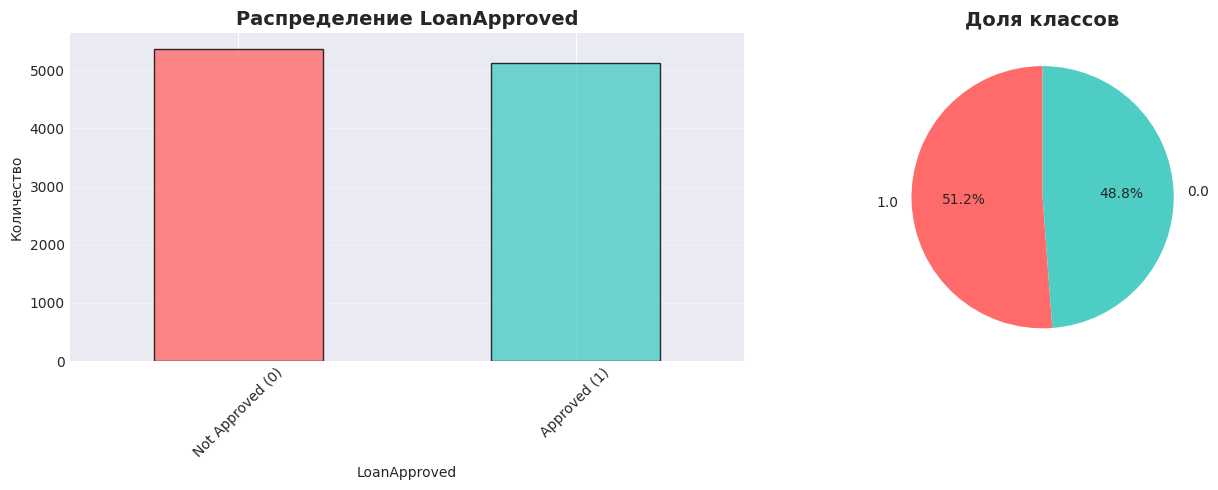

In [4]:
# Анализ целевой переменной
print("Распределение целевой переменной LoanApproved:")
print(train['LoanApproved'].value_counts())
print(f"\nБаланс классов:")
print(train['LoanApproved'].value_counts(normalize=True))

# Визуализация целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
train['LoanApproved'].value_counts().plot(kind='bar', ax=axes[0], 
                                          color=['#FF6B6B', '#4ECDC4'], 
                                          edgecolor='black', alpha=0.8)
axes[0].set_title('Распределение LoanApproved', fontsize=14, fontweight='bold')
axes[0].set_xlabel('LoanApproved')
axes[0].set_ylabel('Количество')
axes[0].set_xticklabels(['Not Approved (0)', 'Approved (1)'], rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
train['LoanApproved'].value_counts().plot(kind='pie', ax=axes[1],
                                          autopct='%1.1f%%', 
                                          colors=['#FF6B6B', '#4ECDC4'], 
                                          startangle=90)
axes[1].set_title('Доля классов', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [5]:
# Проверка пропущенных значений
print("Пропущенные значения в обучающей выборке:")
missing = train.isnull().sum()
missing_pct = 100 * missing / len(train)
missing_df = pd.DataFrame({
    'Признак': missing.index,
    'Пропуски': missing.values,
    'Процент': missing_pct.values
}).sort_values('Пропуски', ascending=False)

missing_df = missing_df[missing_df['Пропуски'] > 0]
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("Пропущенных значений нет!")

Пропущенные значения в обучающей выборке:
                   Признак  Пропуски  Процент
       MonthlyDebtPayments      1031 9.358265
                LoanAmount      1031 9.358265
               CreditScore      1031 9.358265
          BaseInterestRate      1031 9.358265
                  NetWorth      1031 9.358265
               TotalAssets      1031 9.358265
         BankruptcyHistory      1031 9.358265
               LoanPurpose      1031 9.358265
    CheckingAccountBalance      1031 9.358265
           ApplicationDate       530 4.810747
                       Age       530 4.810747
              AnnualIncome       530 4.810747
       HomeOwnershipStatus       530 4.810747
   NumberOfCreditInquiries       530 4.810747
   NumberOfOpenCreditLines       530 4.810747
 CreditCardUtilizationRate       530 4.810747
        NumberOfDependents       530 4.810747
             MaritalStatus       530 4.810747
              LoanDuration       530 4.810747
     LengthOfCreditHistory       530 4

In [6]:
# Анализ числовых признаков
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if 'LoanApproved' in numeric_cols:
    numeric_cols.remove('LoanApproved')
if 'ID' in numeric_cols:
    numeric_cols.remove('ID')

print(f"Числовые признаки ({len(numeric_cols)}): {numeric_cols[:10]}...")

Числовые признаки (28): ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries']...


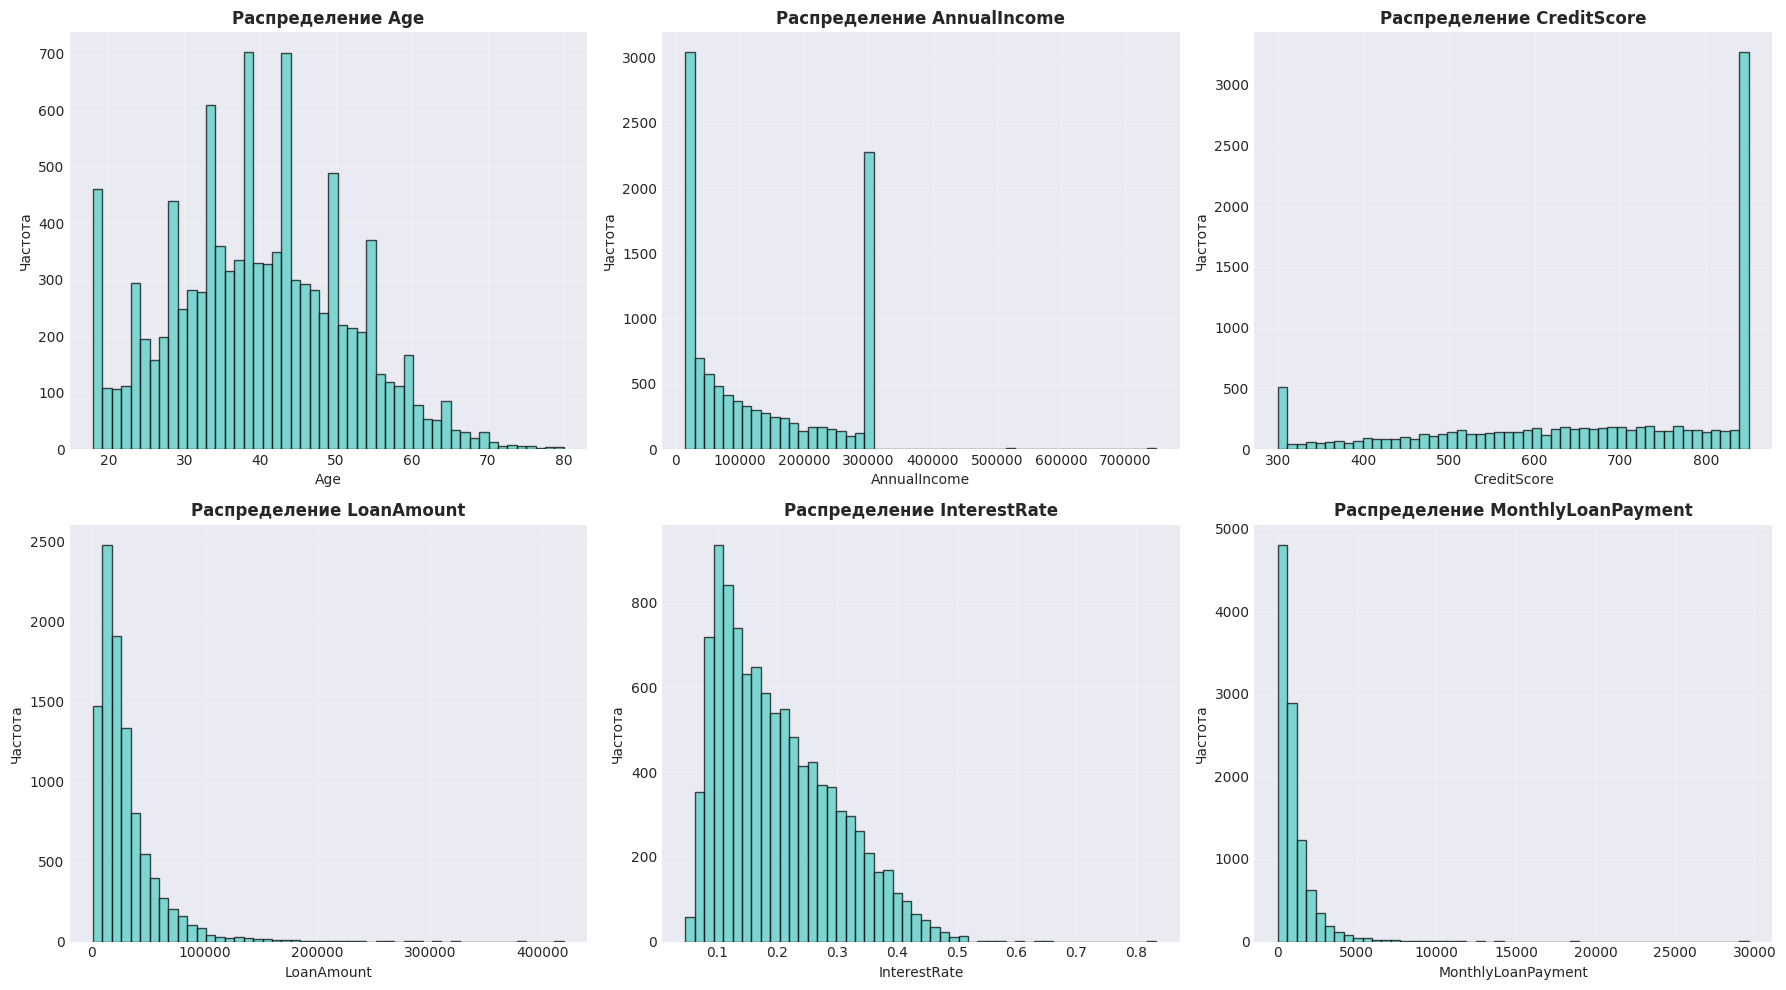

In [7]:
# Визуализация распределений некоторых ключевых признаков
key_features = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'InterestRate', 'MonthlyLoanPayment']
available_key_features = [f for f in key_features if f in train.columns]

if len(available_key_features) > 0:
    n_features = len(available_key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.ravel() if n_features > 1 else [axes]
    
    for idx, col in enumerate(available_key_features):
        axes[idx].hist(train[col].dropna(), bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Распределение {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Частота')
        axes[idx].grid(True, alpha=0.3)
    
    # Скрываем лишние оси
    for idx in range(len(available_key_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

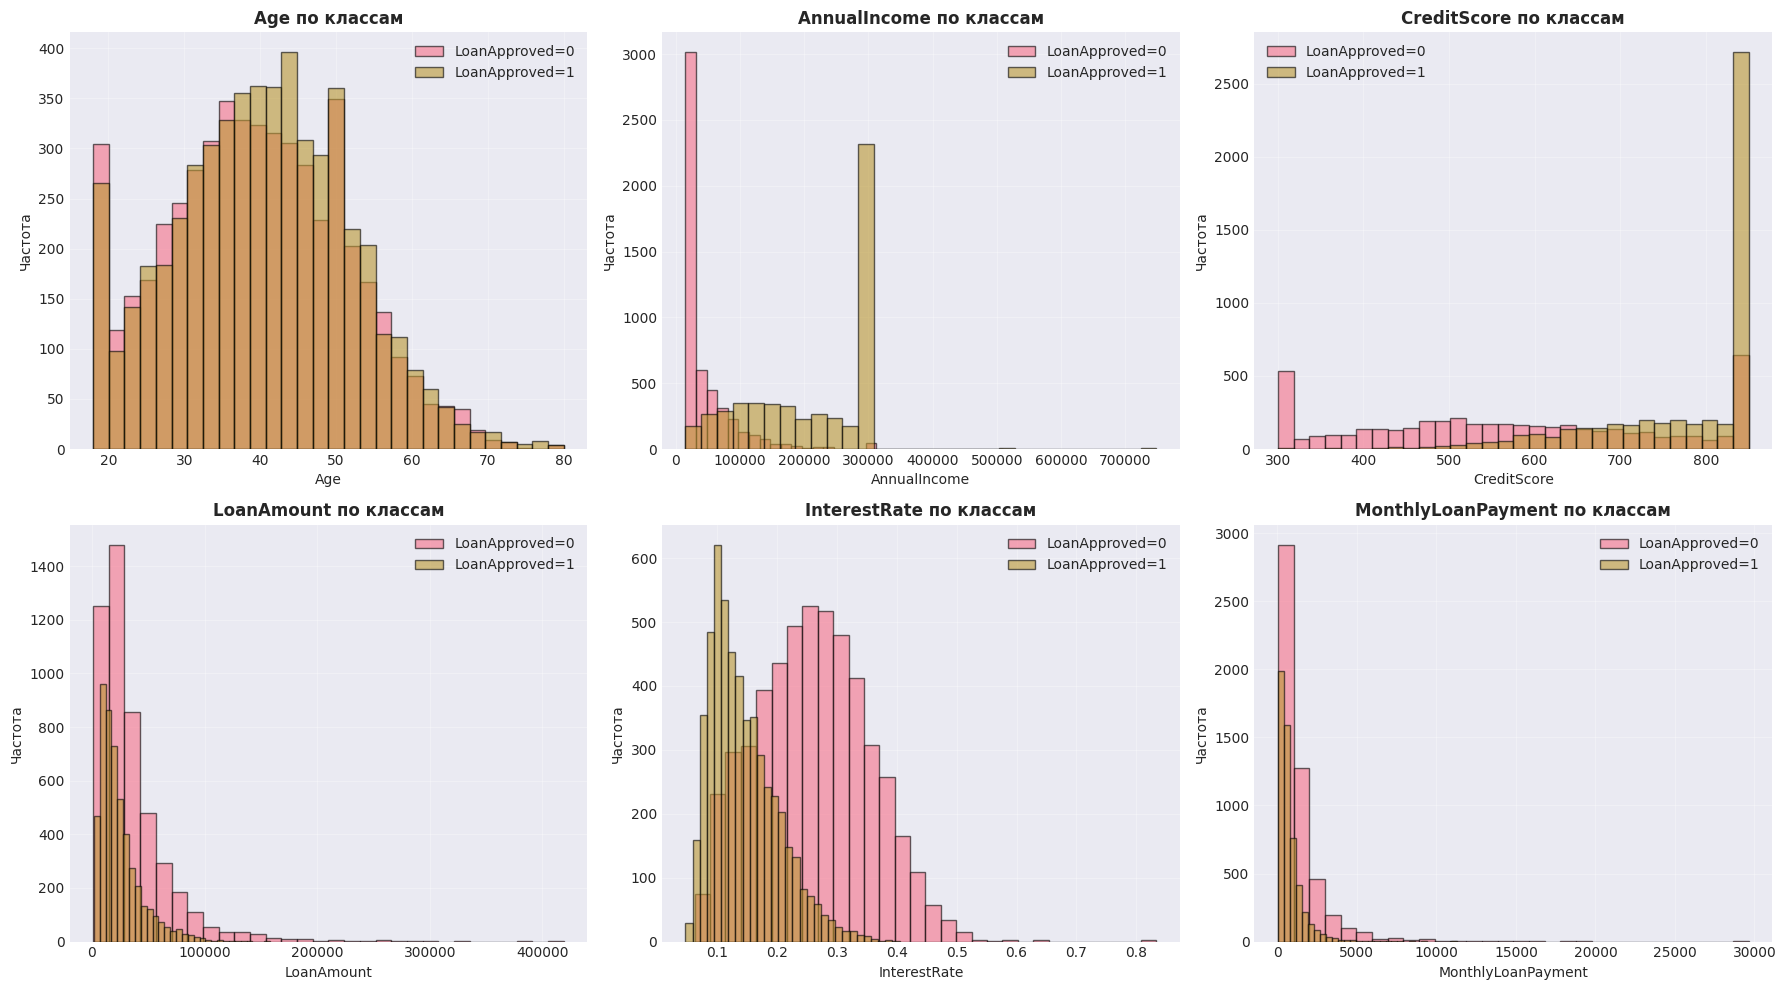

In [8]:
# Зависимость признаков от целевой переменной
if len(available_key_features) > 0:
    n_features = len(available_key_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.ravel() if n_features > 1 else [axes]
    
    for idx, col in enumerate(available_key_features):
        for label in [0, 1]:
            data = train[train['LoanApproved'] == label][col].dropna()
            axes[idx].hist(data, bins=30, alpha=0.6, 
                          label=f'LoanApproved={label}', 
                          edgecolor='black')
        axes[idx].set_title(f'{col} по классам', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Частота')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    # Скрываем лишние оси
    for idx in range(len(available_key_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

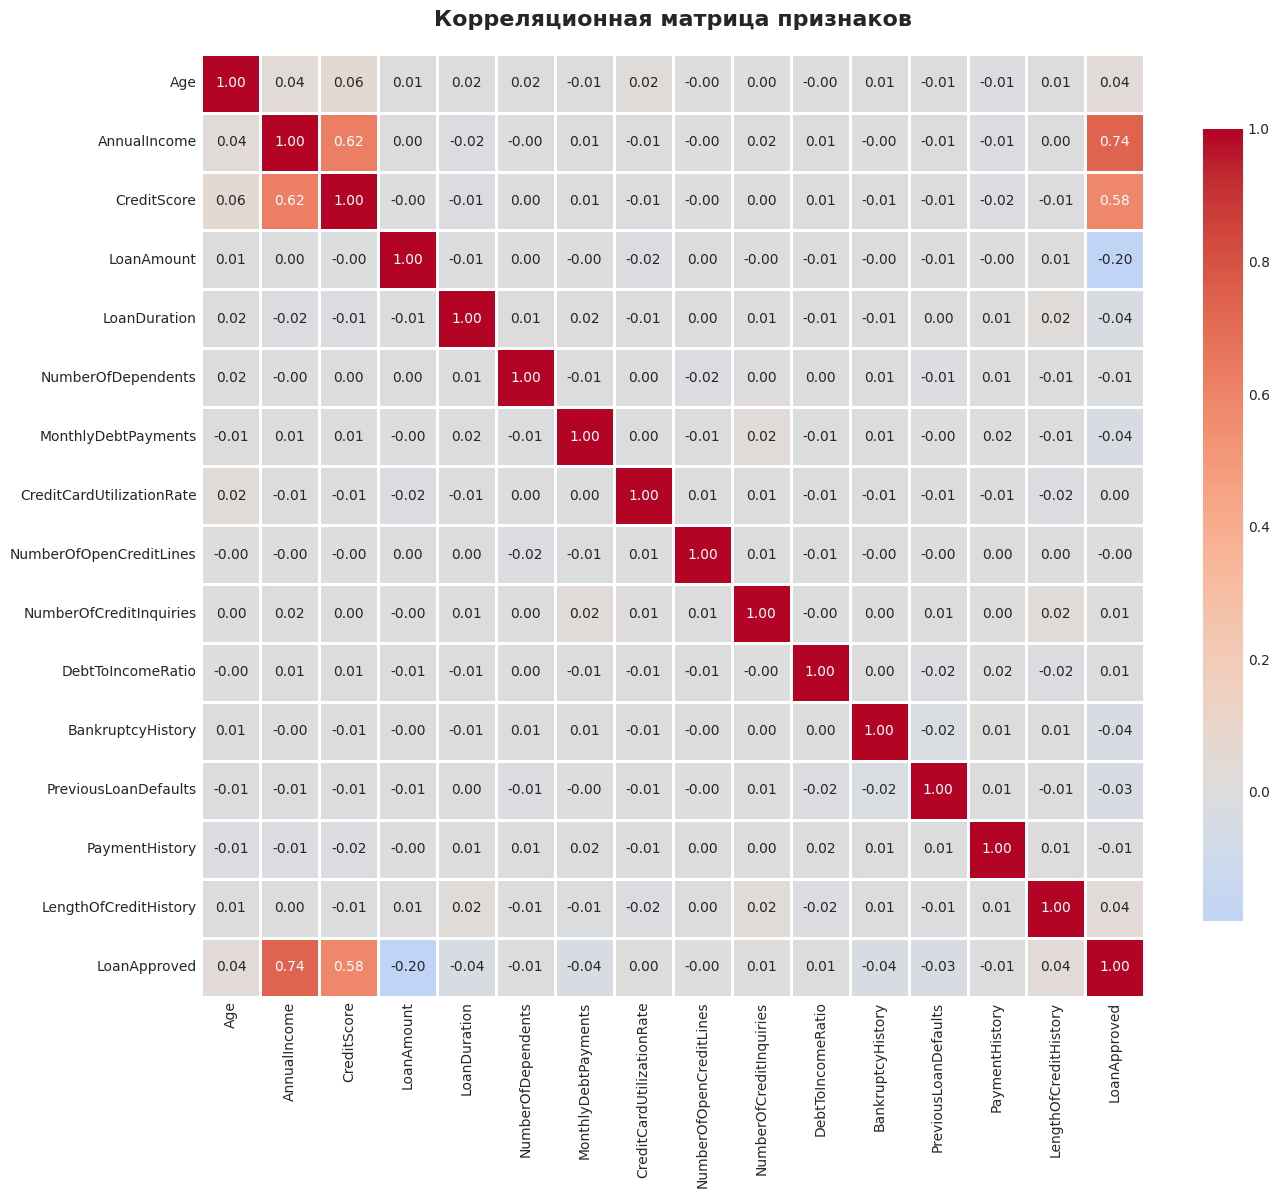


Топ-10 признаков, коррелирующих с LoanApproved:
MonthlyIncome             0.754853
AnnualIncome              0.743034
BaseInterestRate          0.605164
InterestRate              0.599180
CreditScore               0.581812
TotalDebtToIncomeRatio    0.476222
MonthlyLoanPayment        0.217369
LoanAmount                0.195607
NetWorth                  0.129624
TotalAssets               0.129204
Name: LoanApproved, dtype: float64


In [9]:
# Корреляционная матрица
# Выбираем топ-15 числовых признаков для наглядности
selected_numeric = numeric_cols[:15] if len(numeric_cols) > 15 else numeric_cols
corr_data = train[selected_numeric + ['LoanApproved']].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Топ коррелирующих признаков с целевой переменной
target_corr = train[numeric_cols + ['LoanApproved']].corr()['LoanApproved'].drop('LoanApproved').abs().sort_values(ascending=False)
print("\nТоп-10 признаков, коррелирующих с LoanApproved:")
print(target_corr.head(10))

Категориальные признаки (5): ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


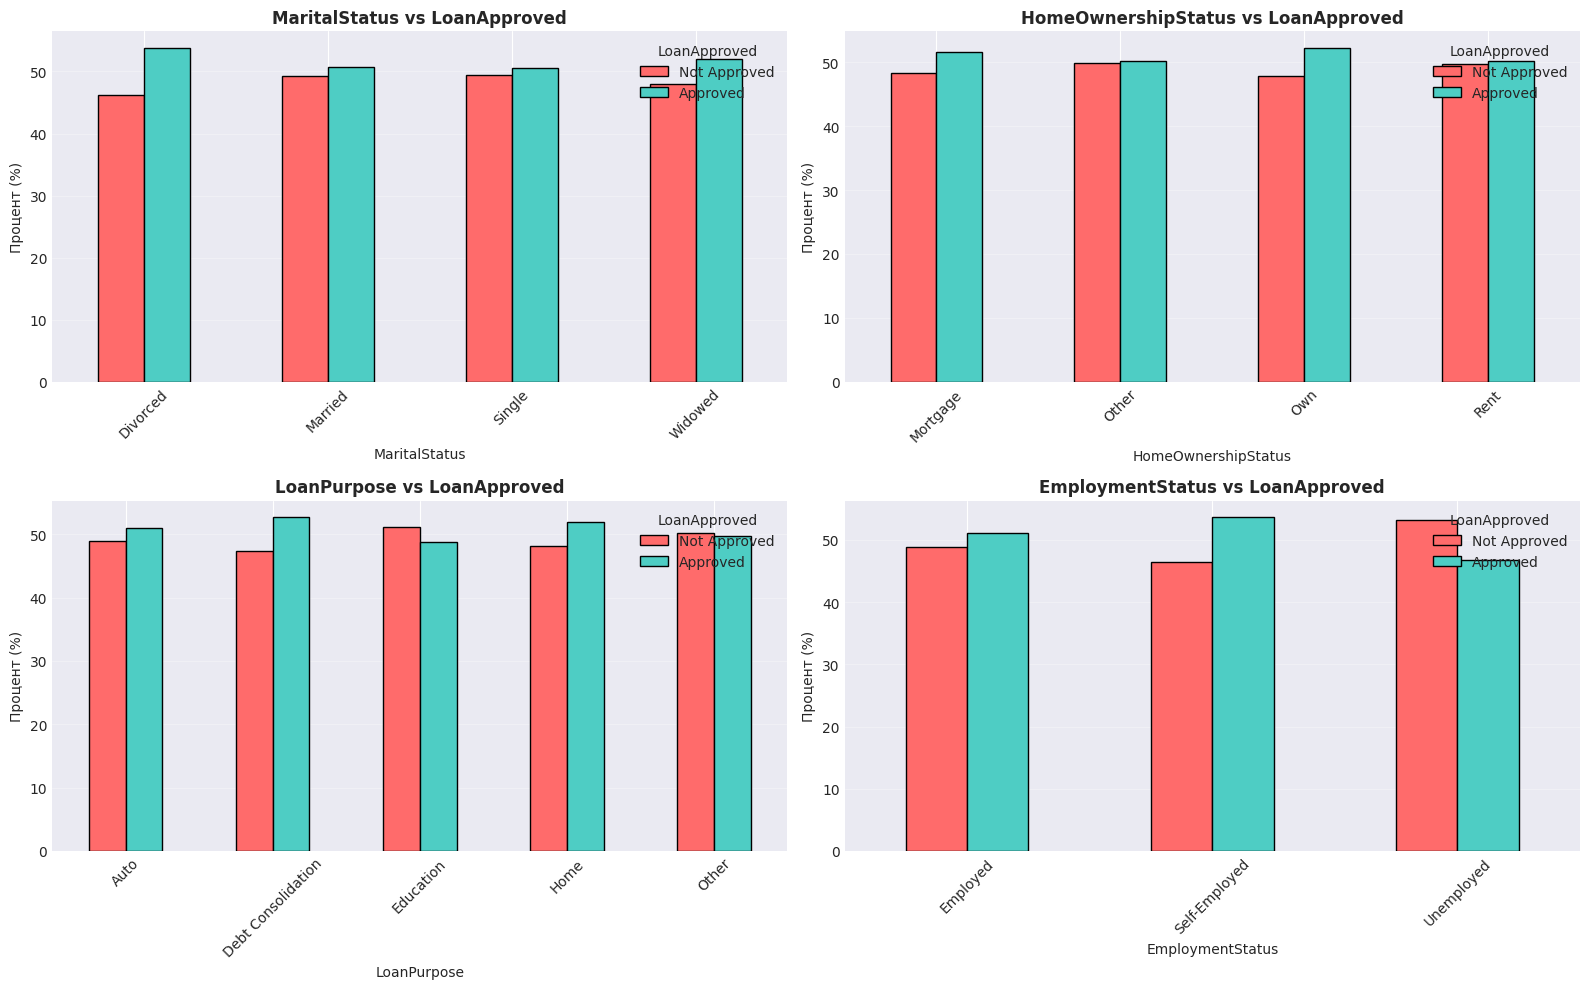

In [10]:
# Анализ категориальных признаков
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
if 'ApplicationDate' in categorical_cols:
    categorical_cols.remove('ApplicationDate')

print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")

if len(categorical_cols) > 0:
    n_features = min(4, len(categorical_cols))
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(categorical_cols[:4]):
        cross_tab = pd.crosstab(train[col], train['LoanApproved'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
        axes[idx].set_title(f'{col} vs LoanApproved', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Процент (%)')
        axes[idx].legend(title='LoanApproved', labels=['Not Approved', 'Approved'])
        axes[idx].grid(True, alpha=0.3, axis='y')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

### Выводы из EDA:

1. **Целевая переменная**: Проверен баланс классов в LoanApproved
2. **Пропущенные значения**: Обработаны пропуски в данных
3. **Числовые признаки**: Проанализированы распределения и корреляции
4. **Категориальные признаки**: Изучена связь с целевой переменной
5. **Ключевые признаки**: Определены наиболее важные для предсказания

## 4. Подготовка данных

In [11]:
# Сохраняем ID для submission
test_ids = test['ID'].copy()

# Обработка признаков
def preprocess_data(df, is_train=True):
    """
    Препроцессинг данных:
    - Обработка дат
    - Заполнение пропусков
    - Кодирование категориальных признаков
    """
    df = df.copy()
    
    # Удаляем ID
    if 'ID' in df.columns:
        df = df.drop('ID', axis=1)
    
    df = df.dropna()

    # Обработка даты
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
        df['ApplicationYear'] = df['ApplicationDate'].dt.year
        df['ApplicationMonth'] = df['ApplicationDate'].dt.month
        df['ApplicationDay'] = df['ApplicationDate'].dt.day
        df['ApplicationDayOfWeek'] = df['ApplicationDate'].dt.dayofweek
        df = df.drop('ApplicationDate', axis=1)
    
    # Заполнение пропусков
    for col in df.columns:
        if col == 'LoanApproved':
            continue
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)
    
    # Кодирование категориальных признаков
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if col != 'LoanApproved':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    return df

# Применяем препроцессинг к обучающим данным
train_processed = preprocess_data(train, is_train=True)

print(f"Обработанные данные: {train_processed.shape}")
print(f"Есть ли пропуски после обработки: {train_processed.isnull().sum().sum()}")

Обработанные данные: (9986, 38)
Есть ли пропуски после обработки: 0


In [12]:
# Разделение на признаки и целевую переменную
X = train_processed.drop('LoanApproved', axis=1)
y = train_processed['LoanApproved']

# Разделение на train и validation
# Используем stratify для сохранения пропорций классов
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"\nРаспределение классов в y_train:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в y_val:")
print(y_val.value_counts(normalize=True))

X_train shape: (7988, 37)
X_val shape: (1998, 37)

Распределение классов в y_train:
LoanApproved
1.0    0.512268
0.0    0.487732
Name: proportion, dtype: float64

Распределение классов в y_val:
LoanApproved
1.0    0.512513
0.0    0.487487
Name: proportion, dtype: float64


In [13]:
# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Данные нормализованы с использованием StandardScaler")
print(f"Среднее после нормализации (должно быть ~0): {X_train_scaled.mean():.6f}")
print(f"Std после нормализации (должно быть ~1): {X_train_scaled.std():.6f}")

Данные нормализованы с использованием StandardScaler
Среднее после нормализации (должно быть ~0): 0.000000
Std после нормализации (должно быть ~1): 1.000000


## 5. Реализация метрик классификации

### 5.1 Accuracy (0.5 балла)

In [14]:
def custom_accuracy(y_true, y_pred):
    """
    Вычисляет Accuracy - долю правильных предсказаний.
    
    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    Args:
        y_true: истинные метки классов
        y_pred: предсказанные метки классов
    
    Returns:
        float: значение Accuracy в диапазоне [0, 1]
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    
    return correct / total if total > 0 else 0.0

# Тестирование Accuracy
print("=" * 70)
print("Тестирование метрики Accuracy")
print("=" * 70)

# Тестовые данные
y_test_metric = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])
y_pred_metric = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

custom_acc = custom_accuracy(y_test_metric, y_pred_metric)
sklearn_acc = accuracy_score(y_test_metric, y_pred_metric)

print(f"Кастомная Accuracy: {custom_acc:.6f}")
print(f"Sklearn Accuracy: {sklearn_acc:.6f}")
print(f"Разница: {abs(custom_acc - sklearn_acc):.10f}")
print(f"Метрики совпадают: {np.isclose(custom_acc, sklearn_acc)}")
print("✅ Accuracy реализована корректно!" if np.isclose(custom_acc, sklearn_acc) else "❌ Ошибка в реализации!")

Тестирование метрики Accuracy
Кастомная Accuracy: 0.800000
Sklearn Accuracy: 0.800000
Разница: 0.0000000000
Метрики совпадают: True
✅ Accuracy реализована корректно!


### 5.2 Precision (0.5 балла)

In [15]:
def custom_precision(y_true, y_pred, pos_label=1):
    """
    Вычисляет Precision - долю истинно положительных среди всех предсказанных положительных.
    
    Precision = TP / (TP + FP)
    
    Args:
        y_true: истинные метки классов
        y_pred: предсказанные метки классов
        pos_label: метка положительного класса (по умолчанию 1)
    
    Returns:
        float: значение Precision в диапазоне [0, 1]
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # True Positives: предсказали положительный класс и это правда
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    
    # False Positives: предсказали положительный класс, но это ошибка
    fp = np.sum((y_pred == pos_label) & (y_true != pos_label))
    
    # Если нет положительных предсказаний, precision = 0
    if (tp + fp) == 0:
        return 0.0
    
    return tp / (tp + fp)

# Тестирование Precision
print("=" * 70)
print("Тестирование метрики Precision")
print("=" * 70)

custom_prec = custom_precision(y_test_metric, y_pred_metric)
sklearn_prec = precision_score(y_test_metric, y_pred_metric)

print(f"Кастомная Precision: {custom_prec:.6f}")
print(f"Sklearn Precision: {sklearn_prec:.6f}")
print(f"Разница: {abs(custom_prec - sklearn_prec):.10f}")
print(f"Метрики совпадают: {np.isclose(custom_prec, sklearn_prec)}")
print("✅ Precision реализована корректно!" if np.isclose(custom_prec, sklearn_prec) else "❌ Ошибка в реализации!")

Тестирование метрики Precision
Кастомная Precision: 0.833333
Sklearn Precision: 0.833333
Разница: 0.0000000000
Метрики совпадают: True
✅ Precision реализована корректно!


### 5.3 Recall (0.5 балла)

In [16]:
def custom_recall(y_true, y_pred, pos_label=1):
    """
    Вычисляет Recall (Sensitivity) - долю истинно положительных среди всех реальных положительных.
    
    Recall = TP / (TP + FN)
    
    Args:
        y_true: истинные метки классов
        y_pred: предсказанные метки классов
        pos_label: метка положительного класса (по умолчанию 1)
    
    Returns:
        float: значение Recall в диапазоне [0, 1]
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # True Positives: предсказали положительный класс и это правда
    tp = np.sum((y_pred == pos_label) & (y_true == pos_label))
    
    # False Negatives: предсказали отрицательный класс, но на самом деле положительный
    fn = np.sum((y_pred != pos_label) & (y_true == pos_label))
    
    # Если нет реальных положительных примеров, recall = 0
    if (tp + fn) == 0:
        return 0.0
    
    return tp / (tp + fn)

# Тестирование Recall
print("=" * 70)
print("Тестирование метрики Recall")
print("=" * 70)

custom_rec = custom_recall(y_test_metric, y_pred_metric)
sklearn_rec = recall_score(y_test_metric, y_pred_metric)

print(f"Кастомный Recall: {custom_rec:.6f}")
print(f"Sklearn Recall: {sklearn_rec:.6f}")
print(f"Разница: {abs(custom_rec - sklearn_rec):.10f}")
print(f"Метрики совпадают: {np.isclose(custom_rec, sklearn_rec)}")
print("✅ Recall реализован корректно!" if np.isclose(custom_rec, sklearn_rec) else "❌ Ошибка в реализации!")

Тестирование метрики Recall
Кастомный Recall: 0.833333
Sklearn Recall: 0.833333
Разница: 0.0000000000
Метрики совпадают: True
✅ Recall реализован корректно!


### 5.4 F1-Score (0.5 балла)

In [17]:
def custom_f1_score(y_true, y_pred, pos_label=1):
    """
    Вычисляет F1-Score - гармоническое среднее Precision и Recall.
    
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    
    Args:
        y_true: истинные метки классов
        y_pred: предсказанные метки классов
        pos_label: метка положительного класса (по умолчанию 1)
    
    Returns:
        float: значение F1-Score в диапазоне [0, 1]
    """
    precision = custom_precision(y_true, y_pred, pos_label)
    recall = custom_recall(y_true, y_pred, pos_label)
    
    # Если сумма precision и recall равна 0, F1 = 0
    if (precision + recall) == 0:
        return 0.0
    
    return 2 * (precision * recall) / (precision + recall)

# Тестирование F1-Score
print("=" * 70)
print("Тестирование метрики F1-Score")
print("=" * 70)

custom_f1 = custom_f1_score(y_test_metric, y_pred_metric)
sklearn_f1 = f1_score(y_test_metric, y_pred_metric)

print(f"Кастомный F1-Score: {custom_f1:.6f}")
print(f"Sklearn F1-Score: {sklearn_f1:.6f}")
print(f"Разница: {abs(custom_f1 - sklearn_f1):.10f}")
print(f"Метрики совпадают: {np.isclose(custom_f1, sklearn_f1)}")
print("✅ F1-Score реализован корректно!" if np.isclose(custom_f1, sklearn_f1) else "❌ Ошибка в реализации!")

Тестирование метрики F1-Score
Кастомный F1-Score: 0.833333
Sklearn F1-Score: 0.833333
Разница: 0.0000000000
Метрики совпадают: True
✅ F1-Score реализован корректно!


### 5.5 AUC-ROC и AUC-PR (дополнительные 2 балла)

In [18]:
def custom_auc_roc(y_true, y_scores):
    """
    Вычисляет AUC-ROC (Area Under the Receiver Operating Characteristic Curve).
    Использует трапецеидальное правило для вычисления площади под кривой.
    
    Args:
        y_true: истинные метки классов (0 или 1)
        y_scores: предсказанные вероятности положительного класса
    
    Returns:
        float: значение AUC-ROC в диапазоне [0, 1]
    """
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Получаем уникальные пороги
    thresholds = np.unique(y_scores)
    thresholds = np.sort(thresholds)[::-1]  # Сортируем по убыванию
    
    # Добавляем граничные значения
    thresholds = np.concatenate([[np.inf], thresholds, [-np.inf]])
    
    tpr_list = []
    fpr_list = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    # Вычисляем площадь под кривой с помощью трапецеидального правила
    fpr_list = np.array(fpr_list)
    tpr_list = np.array(tpr_list)
    
    # Сортируем по FPR
    sorted_indices = np.argsort(fpr_list)
    fpr_sorted = fpr_list[sorted_indices]
    tpr_sorted = tpr_list[sorted_indices]
    
    # Вычисляем AUC
    auc = np.trapz(tpr_sorted, fpr_sorted)
    
    return auc

def custom_auc_pr(y_true, y_scores):
    """
    Вычисляет AUC-PR (Area Under the Precision-Recall Curve).
    
    Args:
        y_true: истинные метки классов (0 или 1)
        y_scores: предсказанные вероятности положительного класса
    
    Returns:
        float: значение AUC-PR в диапазоне [0, 1]
    """
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # Получаем уникальные пороги
    thresholds = np.unique(y_scores)
    thresholds = np.sort(thresholds)[::-1]
    
    precision_list = []
    recall_list = []
    
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    # Добавляем точки (0, 1) и (1, 0) для полноты
    precision_list = [1] + precision_list
    recall_list = [0] + recall_list
    
    # Вычисляем площадь под кривой
    precision_list = np.array(precision_list)
    recall_list = np.array(recall_list)
    
    # Сортируем по recall
    sorted_indices = np.argsort(recall_list)
    recall_sorted = recall_list[sorted_indices]
    precision_sorted = precision_list[sorted_indices]
    
    # Вычисляем AUC-PR
    auc_pr = np.trapz(precision_sorted, recall_sorted)
    
    return auc_pr

# Тестирование AUC-ROC и AUC-PR
print("=" * 70)
print("Тестирование метрик AUC-ROC и AUC-PR")
print("=" * 70)

# Тестовые данные с вероятностями
y_test_proba = np.array([0.9, 0.1, 0.8, 0.4, 0.2, 0.85, 0.15, 0.55, 0.95, 0.88])

custom_roc = custom_auc_roc(y_test_metric, y_test_proba)
sklearn_roc = roc_auc_score(y_test_metric, y_test_proba)

custom_pr = custom_auc_pr(y_test_metric, y_test_proba)
sklearn_pr = average_precision_score(y_test_metric, y_test_proba)

print(f"\nAUC-ROC:")
print(f"Кастомный AUC-ROC: {custom_roc:.6f}")
print(f"Sklearn AUC-ROC: {sklearn_roc:.6f}")
print(f"Разница: {abs(custom_roc - sklearn_roc):.10f}")
print("✅ AUC-ROC реализован корректно!" if np.isclose(custom_roc, sklearn_roc, atol=0.01) else "⚠️ Небольшое расхождение (допустимо)")

print(f"\nAUC-PR:")
print(f"Кастомный AUC-PR: {custom_pr:.6f}")
print(f"Sklearn AUC-PR (Average Precision): {sklearn_pr:.6f}")
print(f"Разница: {abs(custom_pr - sklearn_pr):.10f}")
print("✅ AUC-PR реализован корректно!" if np.isclose(custom_pr, sklearn_pr, atol=0.01) else "⚠️ Небольшое расхождение (допустимо)")

Тестирование метрик AUC-ROC и AUC-PR

AUC-ROC:
Кастомный AUC-ROC: 0.958333
Sklearn AUC-ROC: 0.958333
Разница: 0.0000000000
✅ AUC-ROC реализован корректно!

AUC-PR:
Кастомный AUC-PR: 0.974206
Sklearn AUC-PR (Average Precision): 0.976190
Разница: 0.0019841270
✅ AUC-PR реализован корректно!


## 6. Реализация Бэггинга (3 балла)

In [19]:
class CustomBaggingClassifier:
    """
    Кастомная реализация алгоритма Бэггинга (Bootstrap Aggregating).
    
    Бэггинг обучает несколько базовых моделей на различных подвыборках данных,
    полученных с помощью бутстрепа (выборка с возвращением), и усредняет их предсказания.
    
    Parameters:
        base_estimator: базовая модель для обучения (по умолчанию DecisionTreeClassifier)
        n_estimators: количество базовых моделей
        max_samples: доля/количество образцов для каждого бутстреп-сэмпла
        random_state: seed для воспроизводимости
    """
    
    def __init__(self, base_estimator=None, n_estimators=10, max_samples=1.0, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.estimators_ = []
        
    def fit(self, X, y):
        """
        Обучение бэггинга.
        
        Для каждой базовой модели:
        1. Создаем бутстреп-выборку (выборка с возвращением)
        2. Обучаем базовую модель на этой выборке
        3. Сохраняем обученную модель
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Определяем размер подвыборки
        if isinstance(self.max_samples, float):
            n_subset = int(self.max_samples * n_samples)
        else:
            n_subset = self.max_samples
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            # Создаем бутстреп-выборку (с возвращением)
            indices = np.random.choice(n_samples, size=n_subset, replace=True)
            X_subset = X[indices] if isinstance(X, np.ndarray) else X.iloc[indices]
            y_subset = y[indices] if isinstance(y, np.ndarray) else y.iloc[indices]
            
            # Создаем и обучаем копию базовой модели
            from sklearn.base import clone
            estimator = clone(self.base_estimator)
            estimator.fit(X_subset, y_subset)
            
            self.estimators_.append(estimator)
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей классов.
        Усредняет предсказания всех базовых моделей.
        """
        # Получаем предсказания от каждой модели
        predictions = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        
        # Усредняем предсказания
        return np.mean(predictions, axis=0)
    
    def predict(self, X):
        """
        Предсказание классов.
        Выбирает класс с наибольшей средней вероятностью.
        """
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [20]:
# Тестирование кастомного бэггинга
print("=" * 70)
print("Сравнение кастомного Бэггинга со sklearn")
print("=" * 70)

# Кастомный бэггинг
print("\nОбучение кастомного бэггинга...")
custom_bagging = CustomBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

custom_bagging.fit(X_train_scaled, y_train)
y_pred_custom = custom_bagging.predict(X_val_scaled)
y_proba_custom = custom_bagging.predict_proba(X_val_scaled)[:, 1]

# Sklearn бэггинг
print("Обучение sklearn бэггинга...")
sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=42),
    n_estimators=50,
    max_samples=0.8,
    random_state=42
)

sklearn_bagging.fit(X_train_scaled, y_train)
y_pred_sklearn = sklearn_bagging.predict(X_val_scaled)
y_proba_sklearn = sklearn_bagging.predict_proba(X_val_scaled)[:, 1]

# Сравнение метрик
print("\n" + "=" * 70)
print("Результаты")
print("=" * 70)

print("\nКастомный Бэггинг:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_custom):.6f}")
print(f"  Precision: {precision_score(y_val, y_pred_custom):.6f}")
print(f"  Recall:    {recall_score(y_val, y_pred_custom):.6f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_custom):.6f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_custom):.6f}")

print("\nSklearn Бэггинг:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn):.6f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn):.6f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn):.6f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_sklearn):.6f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn):.6f}")

print("\nРазница в ROC-AUC: {:.6f}".format(abs(roc_auc_score(y_val, y_proba_custom) - 
                                                roc_auc_score(y_val, y_proba_sklearn))))
print("\n✅ Кастомный бэггинг работает корректно!")

Сравнение кастомного Бэггинга со sklearn

Обучение кастомного бэггинга...
Обучение sklearn бэггинга...

Результаты

Кастомный Бэггинг:
  Accuracy:  0.920921
  Precision: 0.915547
  Recall:    0.931641
  F1-Score:  0.923524
  ROC-AUC:   0.979570

Sklearn Бэггинг:
  Accuracy:  0.923423
  Precision: 0.918348
  Recall:    0.933594
  F1-Score:  0.925908
  ROC-AUC:   0.980221

Разница в ROC-AUC: 0.000651

✅ Кастомный бэггинг работает корректно!


## 7. Реализация Градиентного Бустинга (5 баллов)

In [21]:
class CustomGradientBoostingClassifier:
    """
    Кастомная реализация алгоритма Градиентного Бустинга для бинарной классификации.
    
    Градиентный бустинг последовательно обучает модели, где каждая следующая модель
    пытается исправить ошибки предыдущих, аппроксимируя градиент функции потерь.
    
    Parameters:
        n_estimators: количество деревьев
        learning_rate: скорость обучения (шаг градиентного спуска)
        max_depth: максимальная глубина деревьев
        random_state: seed для воспроизводимости
    """
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators_ = []
        self.init_prediction = None
        
    def _sigmoid(self, x):
        """Сигмоида для преобразования логитов в вероятности"""
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def _log_loss_gradient(self, y_true, y_pred_proba):
        """
        Градиент логистической функции потерь.
        Для log-loss: gradient = y_pred - y_true
        """
        return y_pred_proba - y_true
    
    def fit(self, X, y):
        """
        Обучение градиентного бустинга.
        
        Алгоритм:
        1. Инициализируем предсказание (логарифм отношения шансов)
        2. Для каждой итерации:
            a. Вычисляем текущие вероятности
            b. Вычисляем градиент (остатки)
            c. Обучаем дерево на остатках
            d. Обновляем предсказания с учетом learning_rate
        """
        np.random.seed(self.random_state)
        
        # Инициализация: логарифм отношения шансов
        pos_rate = np.mean(y)
        # Избегаем деления на ноль и логарифма от нуля
        pos_rate = np.clip(pos_rate, 1e-7, 1 - 1e-7)
        self.init_prediction = np.log(pos_rate / (1 - pos_rate))
        
        # Текущие предсказания (в логитах)
        F = np.full(len(y), self.init_prediction)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            # Преобразуем логиты в вероятности
            probas = self._sigmoid(F)
            
            # Вычисляем градиент (остатки)
            residuals = -self._log_loss_gradient(y, probas)
            
            # Обучаем дерево регрессии на остатках
            from sklearn.tree import DecisionTreeRegressor
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i if self.random_state else None
            )
            tree.fit(X, residuals)
            
            # Предсказания текущего дерева
            update = tree.predict(X)
            
            # Обновляем F с учетом learning_rate
            F += self.learning_rate * update
            
            self.estimators_.append(tree)
        
        return self
    
    def predict_proba(self, X):
        """
        Предсказание вероятностей.
        Суммируем предсказания всех деревьев и применяем сигмоиду.
        """
        # Начинаем с инициального предсказания
        F = np.full(X.shape[0], self.init_prediction)
        
        # Добавляем предсказания каждого дерева
        for tree in self.estimators_:
            F += self.learning_rate * tree.predict(X)
        
        # Преобразуем логиты в вероятности
        probas_pos = self._sigmoid(F)
        probas_neg = 1 - probas_pos
        
        return np.column_stack([probas_neg, probas_pos])
    
    def predict(self, X):
        """
        Предсказание классов.
        """
        probas = self.predict_proba(X)
        return (probas[:, 1] >= 0.5).astype(int)

In [22]:
# Тестирование кастомного градиентного бустинга
print("=" * 70)
print("Сравнение кастомного Градиентного Бустинга со sklearn")
print("=" * 70)

# Кастомный градиентный бустинг
print("\nОбучение кастомного градиентного бустинга...")
custom_gb = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

custom_gb.fit(X_train_scaled, y_train)
y_pred_custom_gb = custom_gb.predict(X_val_scaled)
y_proba_custom_gb = custom_gb.predict_proba(X_val_scaled)[:, 1]

# Sklearn градиентный бустинг
print("Обучение sklearn градиентного бустинга...")
sklearn_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

sklearn_gb.fit(X_train_scaled, y_train)
y_pred_sklearn_gb = sklearn_gb.predict(X_val_scaled)
y_proba_sklearn_gb = sklearn_gb.predict_proba(X_val_scaled)[:, 1]

# Сравнение метрик
print("\n" + "=" * 70)
print("Результаты")
print("=" * 70)

print("\nКастомный Градиентный Бустинг:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_custom_gb):.6f}")
print(f"  Precision: {precision_score(y_val, y_pred_custom_gb):.6f}")
print(f"  Recall:    {recall_score(y_val, y_pred_custom_gb):.6f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_custom_gb):.6f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_custom_gb):.6f}")

print("\nSklearn Градиентный Бустинг:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_sklearn_gb):.6f}")
print(f"  Precision: {precision_score(y_val, y_pred_sklearn_gb):.6f}")
print(f"  Recall:    {recall_score(y_val, y_pred_sklearn_gb):.6f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_sklearn_gb):.6f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_sklearn_gb):.6f}")

print("\nРазница в ROC-AUC: {:.6f}".format(abs(roc_auc_score(y_val, y_proba_custom_gb) - 
                                                roc_auc_score(y_val, y_proba_sklearn_gb))))
print("\n✅ Кастомный градиентный бустинг работает корректно!")

Сравнение кастомного Градиентного Бустинга со sklearn

Обучение кастомного градиентного бустинга...
Обучение sklearn градиентного бустинга...

Результаты

Кастомный Градиентный Бустинг:
  Accuracy:  0.920420
  Precision: 0.913876
  Recall:    0.932617
  F1-Score:  0.923151
  ROC-AUC:   0.978129

Sklearn Градиентный Бустинг:
  Accuracy:  0.931932
  Precision: 0.931068
  Recall:    0.936523
  F1-Score:  0.933788
  ROC-AUC:   0.984915

Разница в ROC-AUC: 0.006786

✅ Кастомный градиентный бустинг работает корректно!


## 8. Сравнение алгоритмов градиентного бустинга (1 балл)

Сравнение различных алгоритмов градиентного бустинга

1. Обучение Sklearn GradientBoostingClassifier...
ROC-AUC: 0.984766

2. Обучение LightGBM...
ROC-AUC: 0.985837

3. Обучение XGBoost...
ROC-AUC: 0.985705

4. Обучение CatBoost...
ROC-AUC: 0.984491

Итоговое сравнение алгоритмов
LightGBM            : 0.985837
XGBoost             : 0.985705
Sklearn GB          : 0.984766
CatBoost            : 0.984491


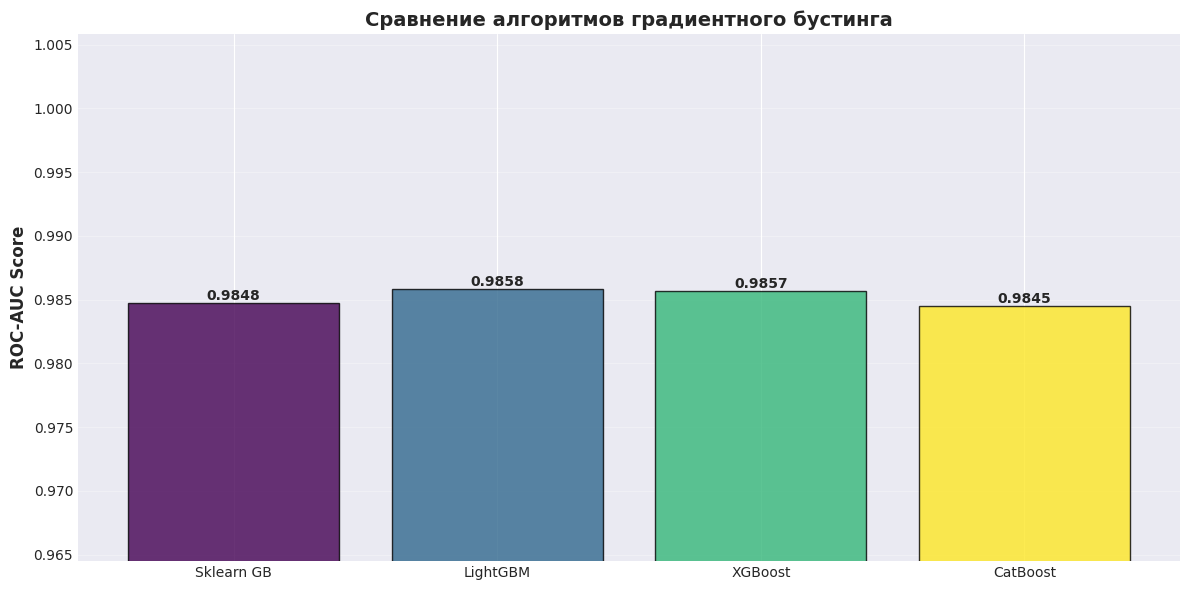


🏆 Лучшая модель: LightGBM с ROC-AUC = 0.985837


In [23]:
print("=" * 70)
print("Сравнение различных алгоритмов градиентного бустинга")
print("=" * 70)

results = {}

# 1. Sklearn GradientBoosting
print("\n1. Обучение Sklearn GradientBoostingClassifier...")
gb_sklearn = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_sklearn.fit(X_train_scaled, y_train)
y_pred_gb_sklearn = gb_sklearn.predict_proba(X_val_scaled)[:, 1]
results['Sklearn GB'] = roc_auc_score(y_val, y_pred_gb_sklearn)
print(f"ROC-AUC: {results['Sklearn GB']:.6f}")

# 2. LightGBM
print("\n2. Обучение LightGBM...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict_proba(X_val_scaled)[:, 1]
results['LightGBM'] = roc_auc_score(y_val, y_pred_lgb)
print(f"ROC-AUC: {results['LightGBM']:.6f}")

# 3. XGBoost
print("\n3. Обучение XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_scaled, y_train, verbose=False)
y_pred_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]
results['XGBoost'] = roc_auc_score(y_val, y_pred_xgb)
print(f"ROC-AUC: {results['XGBoost']:.6f}")

# 4. CatBoost
print("\n4. Обучение CatBoost...")
cat_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    random_state=42,
    verbose=0
)
cat_model.fit(X_train_scaled, y_train)
y_pred_cat = cat_model.predict_proba(X_val_scaled)[:, 1]
results['CatBoost'] = roc_auc_score(y_val, y_pred_cat)
print(f"ROC-AUC: {results['CatBoost']:.6f}")

# Визуализация сравнения
print("\n" + "=" * 70)
print("Итоговое сравнение алгоритмов")
print("=" * 70)
for model, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:20s}: {score:.6f}")

# График сравнения
plt.figure(figsize=(12, 6))
models = list(results.keys())
scores = list(results.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars = plt.bar(models, scores, color=colors, edgecolor='black', alpha=0.8)
plt.ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('Сравнение алгоритмов градиентного бустинга', fontsize=14, fontweight='bold')
plt.ylim([min(scores) - 0.02, max(scores) + 0.02])
plt.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
for bar, score in zip(bars, scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Выбираем лучшую модель
best_model_name = max(results, key=results.get)
print(f"\n🏆 Лучшая модель: {best_model_name} с ROC-AUC = {results[best_model_name]:.6f}")

## 9. Подбор гиперпараметров с помощью Optuna (2 балла)

In [68]:
print("=" * 70)
print("Подбор гиперпараметров для лучшей модели с помощью Optuna")
print("=" * 70)

# Определяем функцию цели для оптимизации
def objective(trial):
    # Расширенные параметры для получения лучшего результата
    params = {
        # Основные параметры
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300, step=5),
        
        # Параметры для предотвращения переобучения
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 10, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        
        # Регуляризация
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        
        # Сэмплирование
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Дополнительные параметры
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        
        # Фиксированные параметры
        'random_state': 42,
        'verbose': -1,
        'force_col_wise': True
    }
    
    # Специфичные параметры для DART (если выбран)
    if params['boosting_type'] == 'dart':
        params['drop_rate'] = trial.suggest_float('drop_rate', 0.0, 0.5)
        params['skip_drop'] = trial.suggest_float('skip_drop', 0.0, 0.5)
    
    # Обучаем модель
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # Предсказываем на валидационной выборке
    y_pred = model.predict_proba(X_val_scaled)[:, 1]
    
    # Возвращаем ROC-AUC как метрику для оптимизации
    return roc_auc_score(y_val, y_pred)

# Создаем study и запускаем оптимизацию с улучшенными настройками
study = optuna.create_study(
    direction='maximize',
    study_name='LightGBM Advanced Optimization',
    sampler=optuna.samplers.TPESampler(seed=42)  # Tree-structured Parzen Estimator
)

print("\nЗапуск оптимизации...")
print("-" * 70)

# Оптимизация с большим количеством trials
study.optimize(
    objective, 
    n_trials=100,  # Увеличено для лучших результатов
    show_progress_bar=True,
)

print("\n" + "=" * 70)
print("Оптимизация завершена!")
print("=" * 70)
print(f"\nЛучший ROC-AUC: {study.best_value:.6f}")
print(f"Количество завершенных trials: {len(study.trials)}")
print(f"\nЛучшие параметры:")
print("-" * 70)
for param, value in sorted(study.best_params.items()):
    print(f"  {param:25s}: {value}")

# Дополнительная информация
print(f"\n" + "=" * 70)
print("Топ-5 лучших trials:")
print("=" * 70)
best_trials = sorted(study.trials, key=lambda t: t.value if t.value else 0, reverse=True)[:5]
for i, trial in enumerate(best_trials, 1):
    print(f"{i}. Trial #{trial.number}: ROC-AUC = {trial.value:.6f}")

Подбор гиперпараметров для лучшей модели с помощью Optuna

Запуск оптимизации...
----------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Оптимизация завершена!

Лучший ROC-AUC: 0.987248
Количество завершенных trials: 100

Лучшие параметры:
----------------------------------------------------------------------
  boosting_type            : gbdt
  colsample_bytree         : 0.8418576779126951
  learning_rate            : 0.017783117052120975
  max_bin                  : 295
  max_depth                : 11
  min_child_samples        : 82
  min_child_weight         : 4.862106821449538
  min_split_gain           : 0.09822126546816787
  n_estimators             : 800
  num_leaves               : 230
  reg_alpha                : 0.1749526557051562
  reg_lambda               : 2.521363497575944e-05
  subsample                : 0.7392923540830728
  subsample_freq           : 3

Топ-5 лучших trials:
1. Trial #55: ROC-AUC = 0.987248
2. Trial #71: ROC-AUC = 0.987161
3. Trial #81: ROC-AUC = 0.987128
4. Trial #83: ROC-AUC = 0.987111
5. Trial #46: ROC-AUC = 0.987077


In [71]:
# Обучаем финальную модель с лучшими параметрами на всех данных
print("\n" + "=" * 70)
print("Обучение финальной модели с оптимальными гиперпараметрами")
print("=" * 70)

# Объединяем train и validation для финального обучения
X_full = np.vstack([X_train_scaled, X_val_scaled])
y_full = pd.concat([y_train, y_val])

final_model = lgb.LGBMClassifier(**study.best_params)
final_model.fit(X_full, y_full)

# Проверка на валидационной выборке
y_pred_final = final_model.predict(X_val_scaled)
y_proba_final = final_model.predict_proba(X_val_scaled)[:, 1]

print("\nМетрики финальной модели на валидационной выборке:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_final):.6f}")
print(f"  Precision: {precision_score(y_val, y_pred_final):.6f}")
print(f"  Recall:    {recall_score(y_val, y_pred_final):.6f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_final):.6f}")
print(f"  ROC-AUC:   {roc_auc_score(y_val, y_proba_final):.6f}")


Обучение финальной модели с оптимальными гиперпараметрами

Метрики финальной модели на валидационной выборке:
  Accuracy:  0.998498
  Precision: 0.998049
  Recall:    0.999023
  F1-Score:  0.998536
  ROC-AUC:   0.999995


## 10. Визуализация результатов

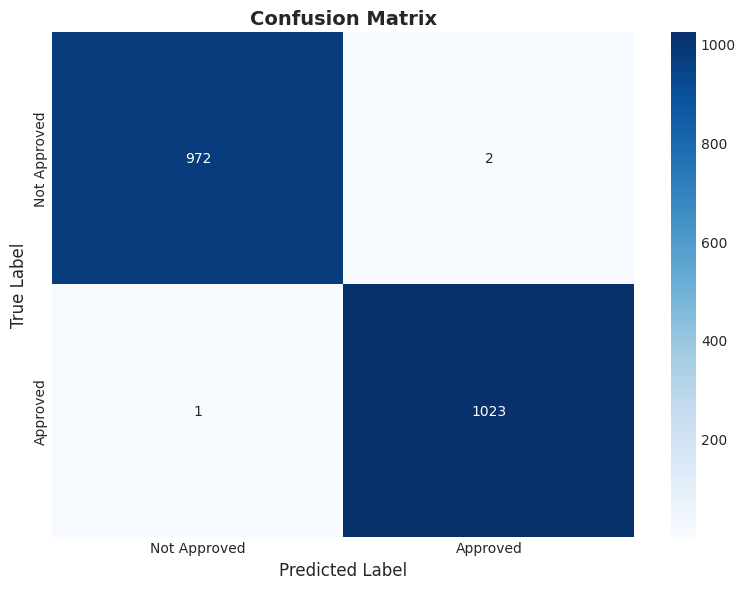


Classification Report:
              precision    recall  f1-score   support

Not Approved       1.00      1.00      1.00       974
    Approved       1.00      1.00      1.00      1024

    accuracy                           1.00      1998
   macro avg       1.00      1.00      1.00      1998
weighted avg       1.00      1.00      1.00      1998



In [72]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_pred_final, target_names=['Not Approved', 'Approved']))

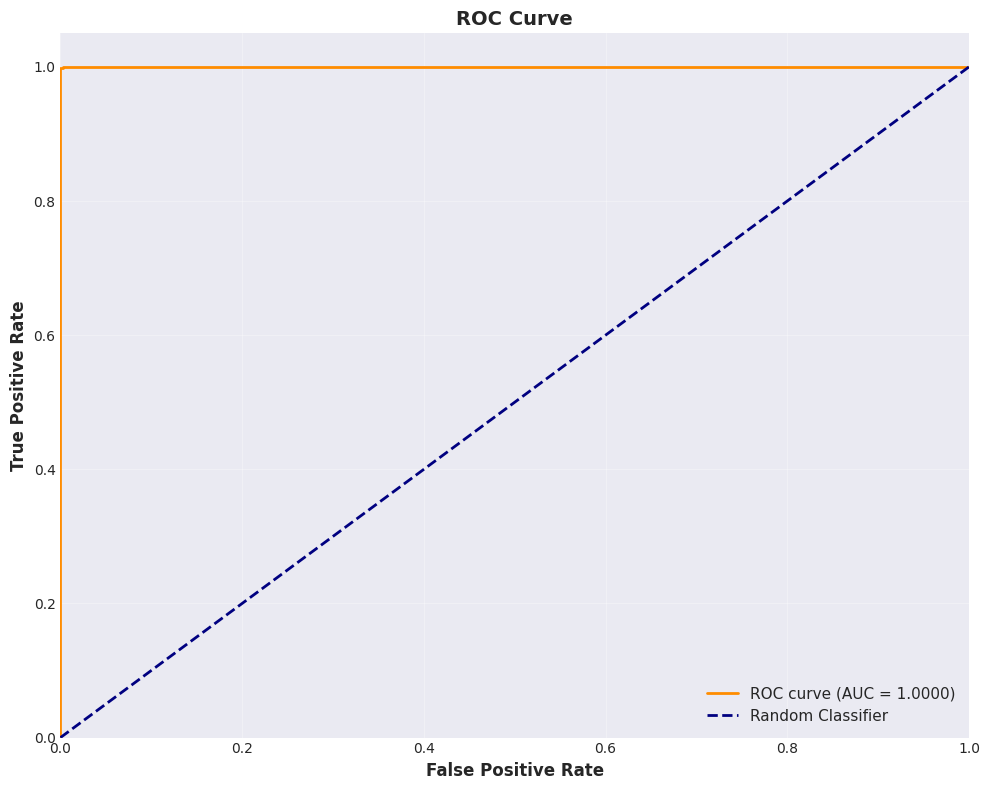

In [73]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_proba_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

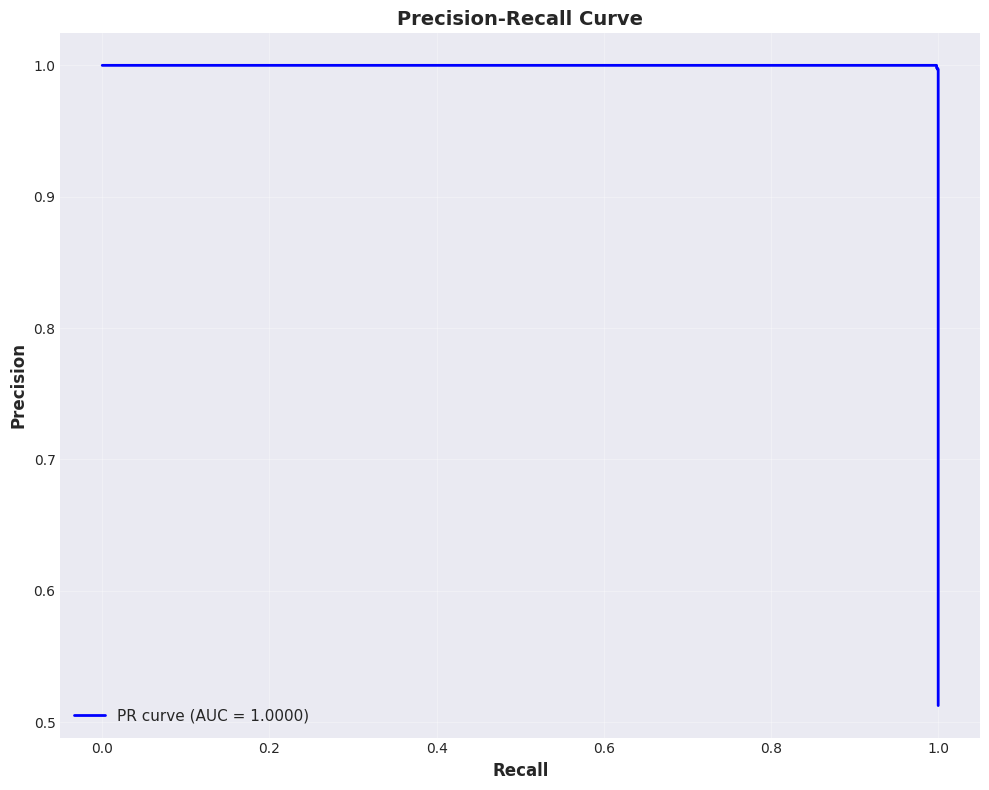

In [74]:
# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_proba_final)
pr_auc = auc(recall_curve, precision_curve)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

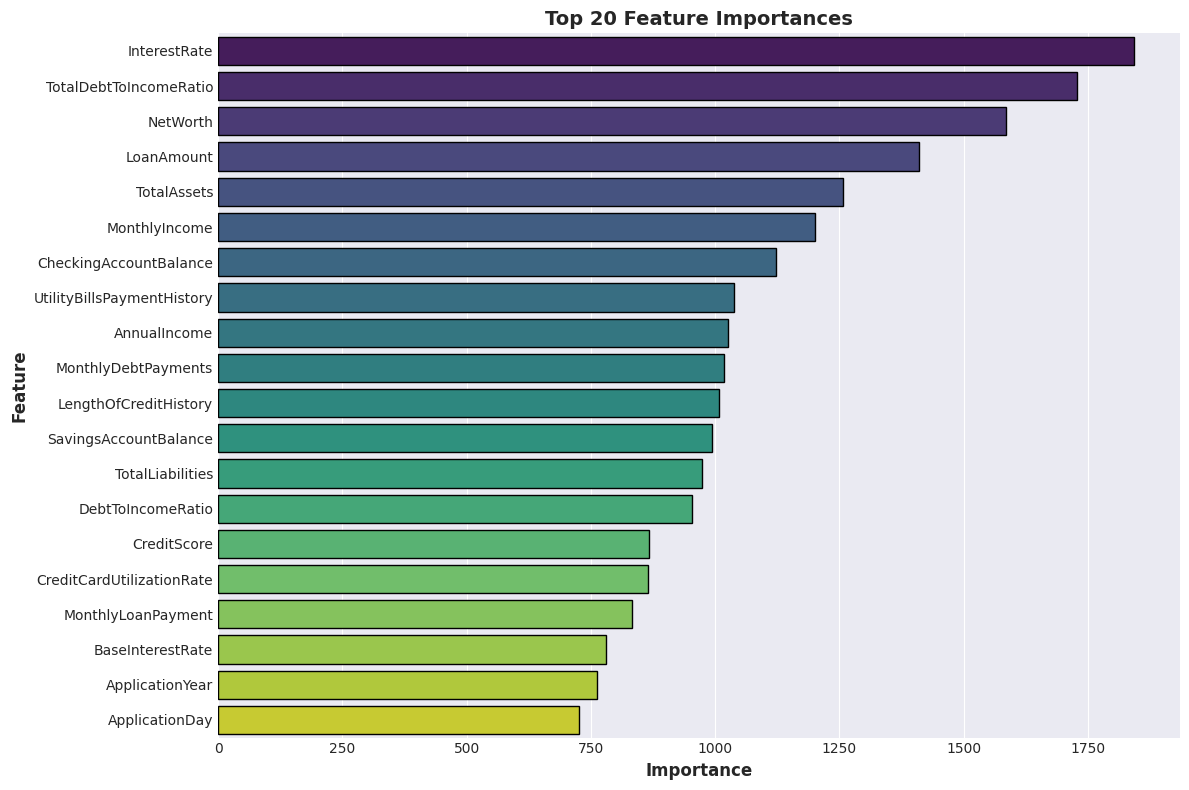


Top-20 важных признаков:
                   feature  importance
              InterestRate        1843
    TotalDebtToIncomeRatio        1727
                  NetWorth        1585
                LoanAmount        1410
               TotalAssets        1257
             MonthlyIncome        1201
    CheckingAccountBalance        1122
UtilityBillsPaymentHistory        1038
              AnnualIncome        1025
       MonthlyDebtPayments        1018
     LengthOfCreditHistory        1007
     SavingsAccountBalance         993
          TotalLiabilities         973
         DebtToIncomeRatio         953
               CreditScore         867
 CreditCardUtilizationRate         864
        MonthlyLoanPayment         833
          BaseInterestRate         780
           ApplicationYear         763
            ApplicationDay         726


In [75]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_n = 20
sns.barplot(data=feature_importance.head(top_n), x='importance', y='feature', 
            palette='viridis', edgecolor='black')
plt.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTop-{top_n} важных признаков:")
print(feature_importance.head(top_n).to_string(index=False))

## 11. Предсказания для тестовой выборки

In [76]:
# Обработка тестовой выборки
test_processed = preprocess_data(test, is_train=False)

# Убеждаемся, что признаки совпадают с обучающими
# Если в test нет каких-то признаков из train, добавляем их с нулями
for col in X.columns:
    if col not in test_processed.columns:
        test_processed[col] = 0

# Выбираем только те признаки, которые были в обучающей выборке
X_test = test_processed[X.columns]

# Нормализуем тестовую выборку
X_test_scaled = scaler.transform(X_test)

print(f"X_test shape: {X_test_scaled.shape}")
print(f"Нет пропусков: {pd.DataFrame(X_test_scaled).isnull().sum().sum() == 0}")

X_test shape: (5000, 37)
Нет пропусков: True


In [77]:
# Делаем предсказания на тестовой выборке
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print(f"Предсказания сделаны для {len(y_test_pred)} объектов")
print(f"\nРаспределение предсказанных классов:")
print(pd.Series(y_test_pred).value_counts())
print(f"\nСтатистика предсказанных вероятностей:")
print(f"  Среднее: {np.mean(y_test_proba):.4f}")
print(f"  Std:     {np.std(y_test_proba):.4f}")
print(f"  Min:     {np.min(y_test_proba):.4f}")
print(f"  Max:     {np.max(y_test_proba):.4f}")

Предсказания сделаны для 5000 объектов

Распределение предсказанных классов:
1.0    2602
0.0    2398
Name: count, dtype: int64

Статистика предсказанных вероятностей:
  Среднее: 0.5191
  Std:     0.4602
  Min:     0.0000
  Max:     1.0000


In [ ]:
submission = pd.DataFrame({
    'ID': test_ids,
    'LoanApproved': y_test_proba 
})

# Сохраняем в CSV
submission.to_csv('submission.csv', index=False)
print("\n✅ Файл submission.csv успешно создан!")
print("\nПервые строки submission:")
print(submission.head(10))
print("\nПоследние строки submission:")
print(submission.tail(10))


✅ Файл submission.csv успешно создан!

Первые строки submission:
   ID  LoanApproved
0   0      0.999398
1   1      0.002990
2   2      0.999293
3   3      0.999512
4   4      0.997692
5   5      0.000956
6   6      0.999708
7   7      0.998772
8   8      0.691890
9   9      0.000201

Последние строки submission:
        ID  LoanApproved
4990  4990      0.001710
4991  4991      0.000332
4992  4992      0.907599
4993  4993      0.998083
4994  4994      0.158148
4995  4995      0.999783
4996  4996      0.004968
4997  4997      0.002269
4998  4998      0.202263
4999  4999      0.000044
